<a href="https://colab.research.google.com/github/pachterlab/CP_2022/blob/main/notebooks/swissRoll/swissDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn

!pip3 install --quiet umap-learn

In [25]:
import pandas as pd
import numpy as np


import random

import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale

import time
from itertools import combinations

import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline

sns.set_style('white')

In [ ]:
#Generate random points and one set of equidistant points

from numpy import random 

#https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/datasets/samples_generator.py#L1321

n_samples = 10000
noise=0

sml = 4
a = 1
height =   0.866025 #1.73205

def getRoll(sml=4,a=1,height=0.866025):
  t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
  t= np.append(t,np.array([10,10+a,10+(a/2)]))
  t = np.reshape(t, (1,n_samples+3))

  x = t * np.cos(sml*t)

  y = 21 * np.random.rand(1, n_samples)
  y = np.append(y,np.array([10,10,10+height]))
  y = np.reshape(y, (1,n_samples+3))

  y = y

  z = t * np.sin(sml*t)

  X = np.concatenate((x, y, z))
  X += noise * np.random.randn(3, n_samples+3)
  X = X.T
  t = np.squeeze(t)

  return X,t,y




In [ ]:
import itertools
tight_grid = [1,2,2.5,3, 3.5, 4]
neigh_grid = [5,15,30,50,100,200]

rep_pairs = list(itertools.product(tight_grid, neigh_grid))


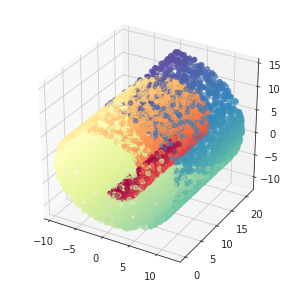

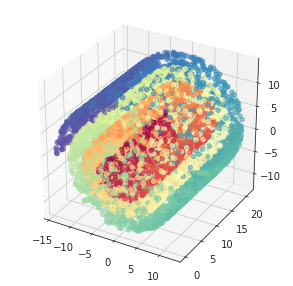

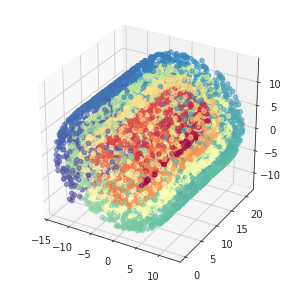

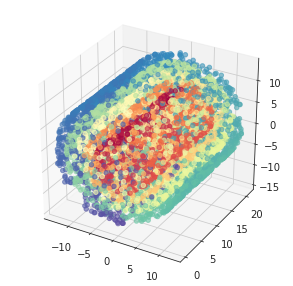

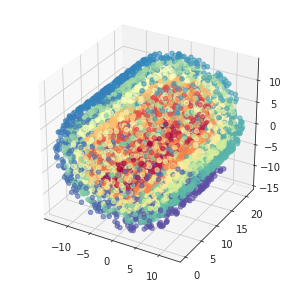

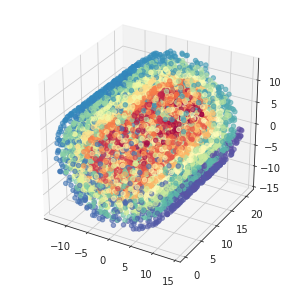

In [ ]:
for i in tight_grid:
  X,t,y = getRoll(sml=i,a=1,height=0.866025)

  fig = plt.figure(figsize=(5,5))
  ax = plt.axes(projection='3d')

  ax.scatter3D(X[:,0],X[:,1],X[:,2], c=t, cmap=plt.cm.Spectral,alpha=0.6)
  plt.savefig('roll_'+str(i)+'.pdf')

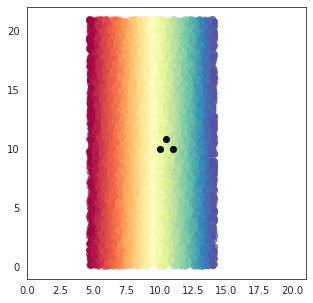

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.scatter(np.reshape(t, (1,n_samples+3)),y,c=t, cmap=plt.cm.Spectral,alpha=0.7)
plt.xlim([0,np.max(y)])
plt.scatter(t[-3:],y[0,-3:], c='black')

#Scale axes here

In [ ]:
from sklearn.metrics import pairwise_distances
pairwise_distances(np.array([[10.,10.], [10+a,10.], [10+(a/2),10+height]])) #Check equidistance 10,10+a,10+(a/2)

array([[0.        , 1.        , 0.99999965],
       [1.        , 0.        , 0.99999965],
       [0.99999965, 0.99999965, 0.        ]])

Generate umap embeddings across grid of tightnesses and n_neighbors

In [58]:
tight_grid

[1, 2, 2.5, 3, 3.5, 4]

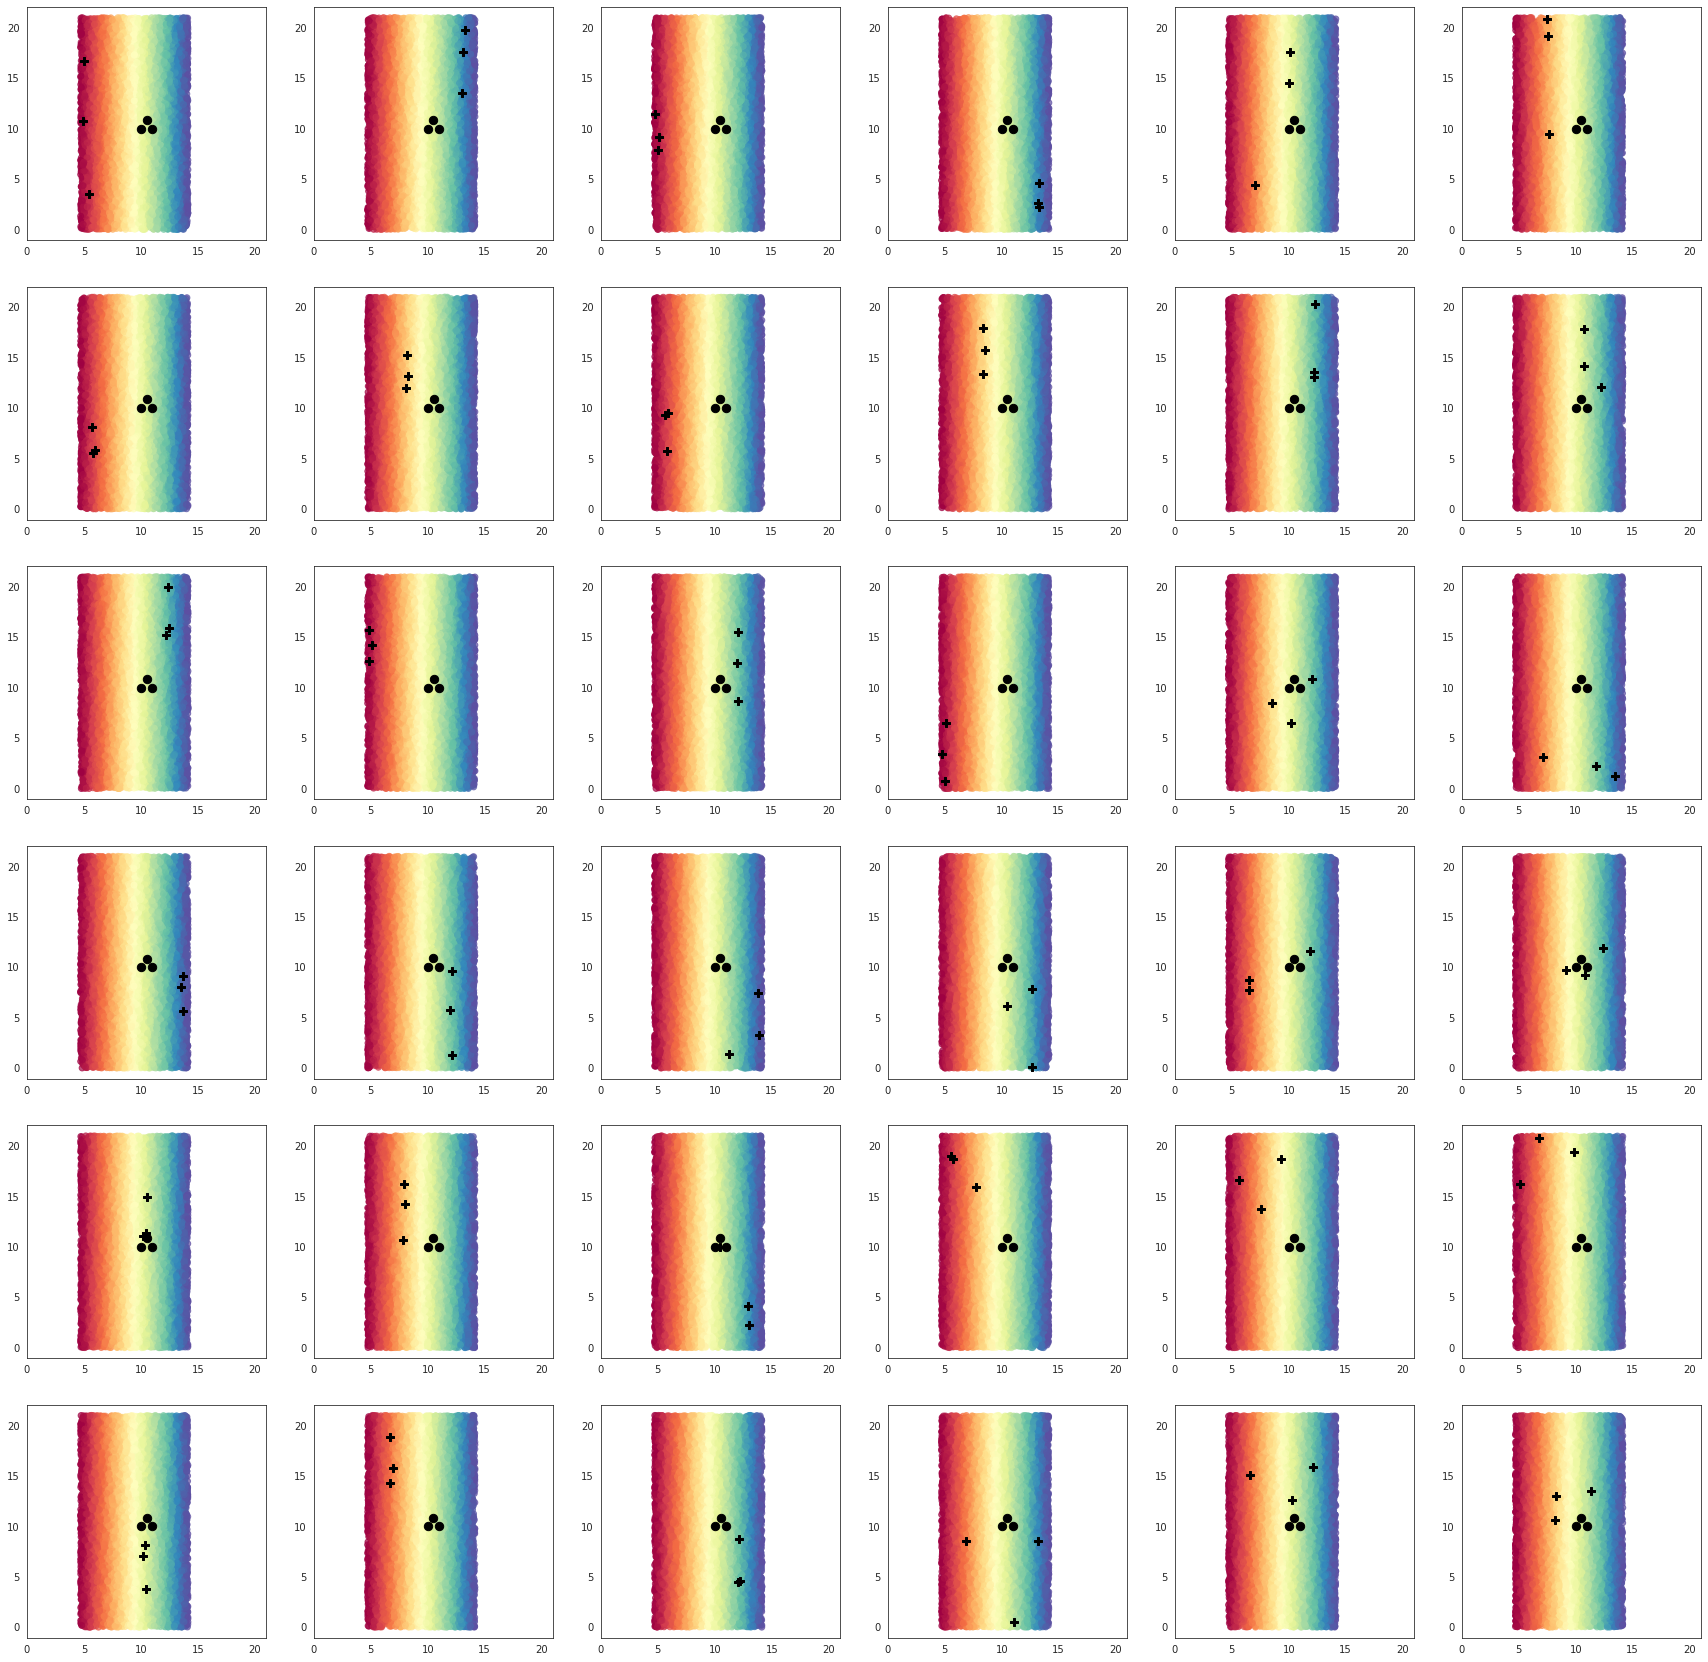

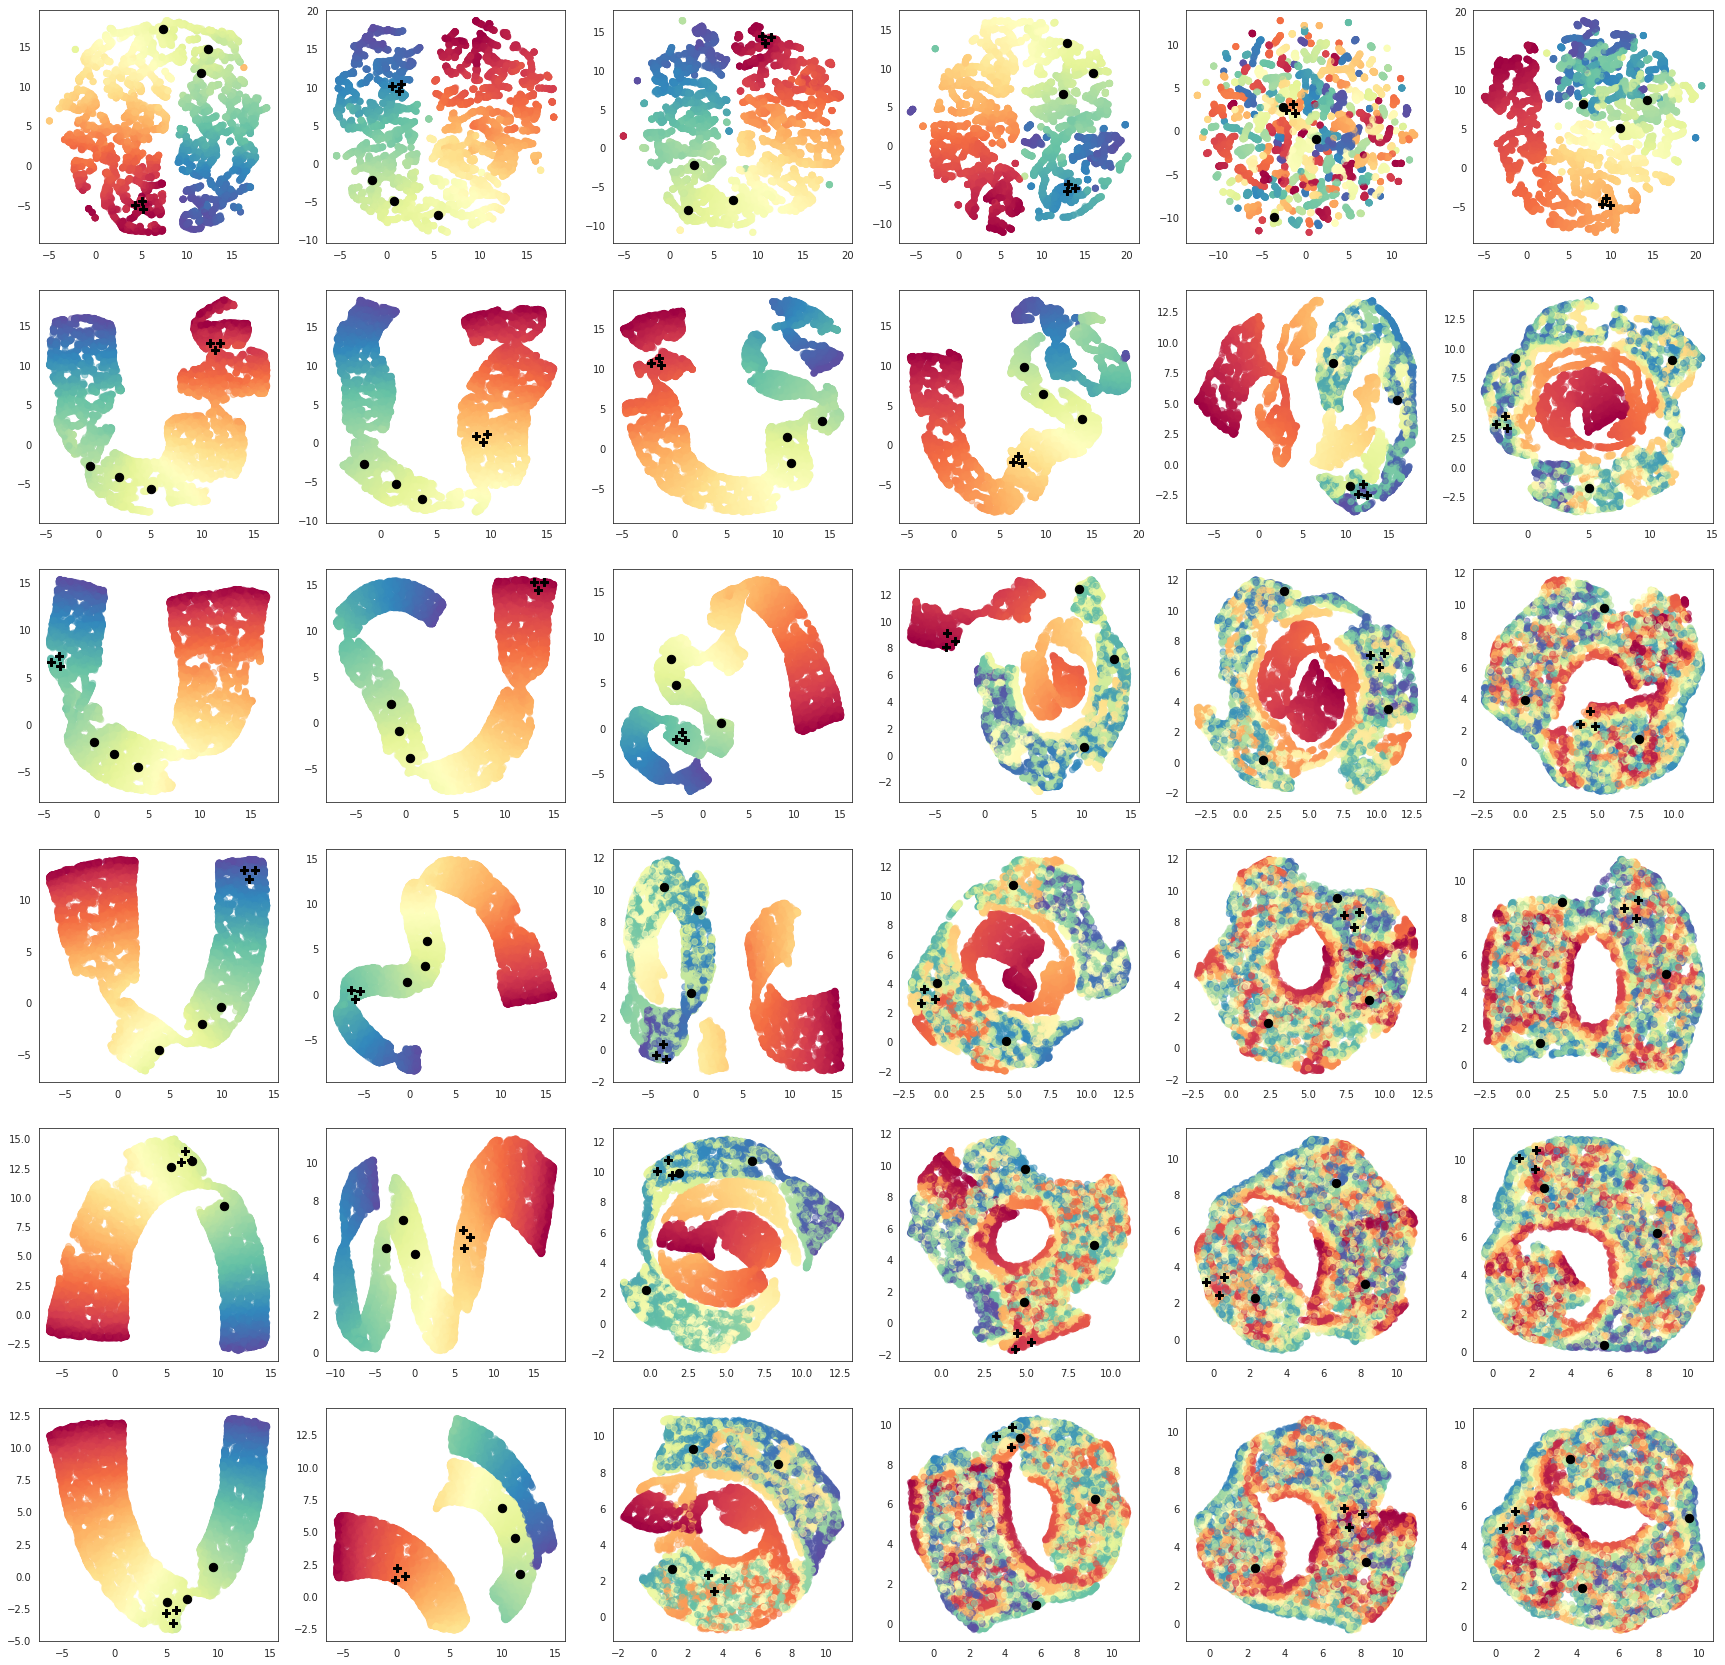

In [67]:
#Get umap embedding, plot in grid

fig, axs = plt.subplots(len(tight_grid), len(neigh_grid),figsize=(30,30))

fig2, axs2 = plt.subplots(len(tight_grid), len(neigh_grid),figsize=(30,30))


for i in rep_pairs:

  X,t,y = getRoll(sml=i[0],a=1,height=0.866025)

  reducer = umap.UMAP(n_components = 2, random_state = 42, n_neighbors=i[1])

  umap2d = reducer.fit_transform(X)


  #Get equid pts in umap

  #Get pairwise distances in embedding
  dists =  pairwise_distances(umap2d) 
  std = np.std(dists)

  thresh = 1000 #2.5
  d=1
  low_values = dists <= (d+std/thresh)
  high_values = dists >= (d-std/thresh)

  known_values = high_values & low_values
  known_values.shape

  #Make graph
  adjacency_matrix = known_values.astype(int)
  rows, cols = np.where(adjacency_matrix == 1)
  edges = zip(rows.tolist(), cols.tolist())
  gr = nx.Graph()
  all_rows = range(0, adjacency_matrix.shape[0])
  for n in all_rows:
    gr.add_node(n)

  gr.add_edges_from(edges)
  cliques = list(nx.find_cliques(gr))

  cliquesSub = [i for i in cliques if len(i) >= 3]

  r = neigh_grid.index(i[1])
  c = tight_grid.index(i[0])

  #Save fig of umap equid cells on original plane
  axs[r,c].scatter(np.reshape(t, (1,n_samples+3)),y,c=t, cmap=plt.cm.Spectral,alpha=0.7)
  axs[r,c].set_xlim([0,np.max(y)])
  axs[r,c].scatter(t[cliquesSub[0]],y[0,cliquesSub[0]], c='black',marker="P",s=70)
  axs[r,c].scatter(t[-3:],y[0,-3:], c='black',s=70)
  #plt.savefig('umap_equid_'+str(i[0])+'_'+str(i[1])+'.pdf') 

  #Save fig of umap with equid cells and original equid cells (from plane)
  #fig = plt.figure(figsize=(5,5))
  axs2[r,c].scatter(umap2d[:,0],umap2d[:,1], c=t, cmap=plt.cm.Spectral,alpha=0.5)
  axs2[r,c].scatter(umap2d[-3:,0],umap2d[-3:,1], c='black',s=70)
  axs2[r,c].scatter(umap2d[cliquesSub[0],0],umap2d[cliquesSub[0],1], c='black',s=70,marker="P")

  pairwise_distances(np.array([[umap2d[-3,0],umap2d[-3,1]], 
                             [umap2d[-2,0],umap2d[-2,1]], 
                             [umap2d[-1,0],umap2d[-1,1]]]))
  
  
fig.savefig('umap_equid.pdf') 

fig2.savefig('umaps.pdf') 




In [71]:
fig.savefig('umap_equid.pdf') 

In [68]:
!rm umap_*.pdf

In [69]:
from google.colab import files

!zip rolls.zip roll*.pdf

  adding: roll_1.pdf (deflated 3%)
  adding: roll_2.5.pdf (deflated 3%)
  adding: roll_2.pdf (deflated 3%)
  adding: roll_3.5.pdf (deflated 3%)
  adding: roll_3.pdf (deflated 3%)
  adding: roll_4.pdf (deflated 3%)


In [70]:
!zip umaps.zip umap*.pdf

  adding: umaps.pdf (deflated 3%)


In [ ]:
files.download('rolls.zip')
files.download('umaps.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# pairwise_distances(np.array([[umap2d[-3,0],umap2d[-3,1]], 
#                              [umap2d[-2,0],umap2d[-2,1]], 
#                              [umap2d[-1,0],umap2d[-1,1]]])) #Check equidistance

array([[ 0.       , 10.434432 ,  7.9932055],
       [10.434432 ,  0.       ,  7.414438 ],
       [ 7.9932055,  7.414438 ,  0.       ]], dtype=float32)